# Modeling: Regression
- Use n-1 year on-field stats and n year for talent stats to predict year n results
- Treat data as set of features at start of each year and try to regress on various outcomes

In [10]:
#!pip install --q xgboost

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [40]:
df = pd.read_csv('data/working_df.csv')
df.head()

,team,team_id,year,conference,games_played,expected_wins,wins,losses,win_pct,prev_win_pct,...,off_explode,def_explode,off_ppa,def_ppa,off_success_rate,def_success_rate,coach,career_win_pct,sor,sos
0,Air Force,2005,2014,Mountain West,13,9.7,10,3,0.769231,0.166667,...,0.860561,0.902638,0.096601,0.214295,0.439644,0.518913,Troy Calhoun,0.544444,115.0,113
1,Air Force,2005,2015,Mountain West,14,8.2,8,6,0.571429,0.769231,...,1.089935,1.425767,0.207059,0.138795,0.451837,0.375831,Troy Calhoun,0.572816,48.0,86
2,Air Force,2005,2016,Mountain West,13,9.4,10,3,0.769231,0.571429,...,1.154045,1.549206,0.272449,0.172654,0.474216,0.357631,Troy Calhoun,0.572650,71.0,113
3,Air Force,2005,2017,Mountain West,12,4.4,5,7,0.416667,0.769231,...,1.027586,1.534094,0.227697,0.158770,0.483333,0.366048,Troy Calhoun,0.592308,49.0,82
4,Air Force,2005,2018,Mountain West,12,6.4,5,7,0.416667,0.416667,...,1.095699,1.374592,0.235542,0.247661,0.488398,0.422096,Troy Calhoun,0.577465,94.0,86


In [41]:
# Sort the data in time order
df = df.sort_values(by='year').reset_index(drop=True)

In [25]:
df.year.max()

2022

#### Split Training/Testing Sets
- We'll split by hand so we can do things in temporal order just to be safe
- 2014 - 2023 is 10 years of data so we'll take 2014 to 2021 for trainig

In [42]:
split_year = 2022
df_train = df[df.year <= split_year]
df_test = df[df.year > split_year]

- Can't include coach_win_pct when doing regression

In [43]:
# Grab features you want
X_cols = ['elo', 'prev_win_pct', 'conference_rating', 'talent_level', 
          'usages', 'off_success_rate', 'sos', 'sor', 'career_win_pct']
# Grab the target. Be careful as y_train needs to be a Pandas series or 1D numpy array
y_cols = 'win_pct'

X_train, X_test = df_train[X_cols], df_test[X_cols]
y_train, y_test = df_train[y_cols], df_test[y_cols]

#### Feature Selection

In [44]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, max_depth=4)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=500)

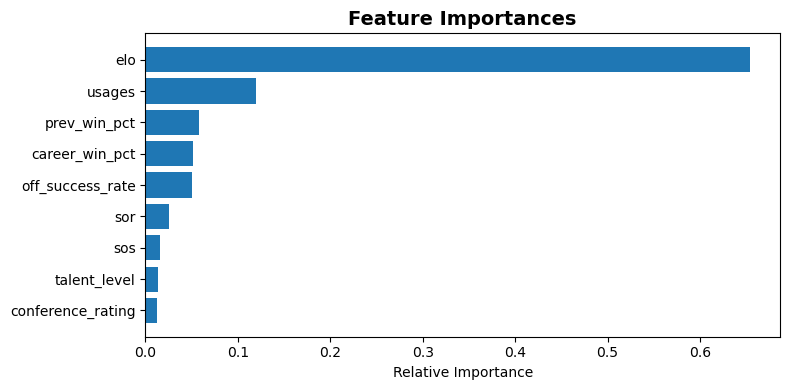

In [45]:
# Use my premade method for graphing feature importance
def graph_feature_importance(model, data):
    """
    model = trained model object from sklearn
    data = Usually X_train
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:] # Get top 10 most important features
    features = data.columns
    f, ax = plt.subplots(figsize=(8, 4))
    plt.title('Feature Importances', fontweight='bold', fontsize=14)
    plt.barh(range(len(indices)), importances[indices])#, color = colormap.colors)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('images/feature_imporances.png')
    plt.show()

graph_feature_importance(rf, X_train)

Let's setup a pipeline to scale our features

In [46]:
from sklearn.preprocessing import StandardScaler

# Scale data, retaining original column titles and structure. Scale on TRAINING data
scaler = StandardScaler()
# Fit and transform on TRAINING data
X_train_scl = pd.DataFrame(scaler.fit_transform(X_train.copy()), 
                            columns = X_train.columns)
# Now transform TEST data
X_test_scl = pd.DataFrame(scaler.transform(X_test.copy()),
                            columns = X_test.columns)

X_train_scl.head()

,elo,prev_win_pct,conference_rating,talent_level,usages,off_success_rate,sos,sor,career_win_pct
0,-1.510068,-1.589183,-0.917165,-1.335420,0.364177,0.213572,1.316892,1.393102,0.289885
1,-0.123588,0.437170,-0.917165,-0.640320,-0.171471,-1.030597,1.077786,-0.041468,0.190762
2,1.423792,1.479295,0.994407,1.379251,-1.581846,0.902212,-0.356852,-1.421905,0.882436
3,-0.315299,-0.460215,-0.416202,-0.576135,-1.178882,0.115205,-0.091178,0.635216,0.424468
4,-1.379979,-0.836538,1.435961,-0.214990,0.531260,-0.716986,-1.313277,0.229205,-0.268018


In [47]:
X_test_scl.head()

,elo,prev_win_pct,conference_rating,talent_level,usages,off_success_rate,sos,sor,career_win_pct
0,0.516589,0.437170,0.041224,-0.004413,-1.213281,0.834517,-0.330284,-0.772288,0.177720
1,-2.235830,-0.836538,-1.214899,-0.378041,0.835941,-1.201582,1.848239,1.528439,-0.274810
2,-0.089354,-0.836538,-0.503331,-0.850670,0.364177,-0.845487,0.679275,1.338968,-0.101996
3,-1.342321,-1.299704,-1.479591,-1.303463,0.270807,-0.704876,0.280765,1.744978,-0.994227
4,0.811002,0.437170,0.859324,0.055778,-1.680130,0.112477,0.041659,-0.745220,0.562803


### BELOW IS IN PROGRESS

In [48]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [49]:
# Make kfold object. Set shuffle=True to maintain time ordering and prevent data leakage from ELO
kfold = TimeSeriesSplit(5)

mses = np.zeros((5,5))
i = 0
for i, (train_index, test_index) in enumerate(kfold.split(X_train)):

    X_tt, y_tt = X_train_scl.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train_scl.iloc[test_index], y_train.iloc[test_index]
    X_ho_base, y_ho_base = X_train.iloc[test_index], y_train.iloc[test_index]

    # Baseline model, take previous winning percentage
    pred0 = X_ho_base['prev_win_pct']

    # Declare Models
    model1 = LinearRegression() # All features
    model2 = LinearRegression() # Just ELO
    model3 = RandomForestRegressor()
    model4 = XGBRegressor() # Do XGB but with fine tuning
    model5 = 


    # Train Models
    model1.fit(X_tt, y_tt)
    model2.fit(X_tt[['elo']], y_tt)
    model3.fit(X_tt, y_tt)
    model4.fit(X_tt, y_tt)

    # add models to list
    models = [None, model1, model2, model3, model4]

    # Get predictions
    pred1 = model1.predict(X_ho)
    pred2 = model2.predict(X_ho[['elo']])
    pred3 = model3.predict(X_ho)
    pred4 = model4.predict(X_ho)

    mses[0,i] = mean_squared_error(y_ho_base, pred0)
    mses[1,i] = mean_squared_error(y_ho, pred1)
    mses[2,i] = mean_squared_error(y_ho, pred2)
    mses[3,i] = mean_squared_error(y_ho, pred3)
    mses[4,i] = mean_squared_error(y_ho, pred4)
    

In [50]:
print(f'Mean MSEs: {np.mean(mses, axis=1)}')
best_model_num = np.argmin(np.mean(mses, axis=1))
print(f'Best Model is model: {best_model_num}')

Mean MSEs: [0.04840192 0.03087379 0.03388201 0.03280786 0.03925309]
Best Model is model: 1


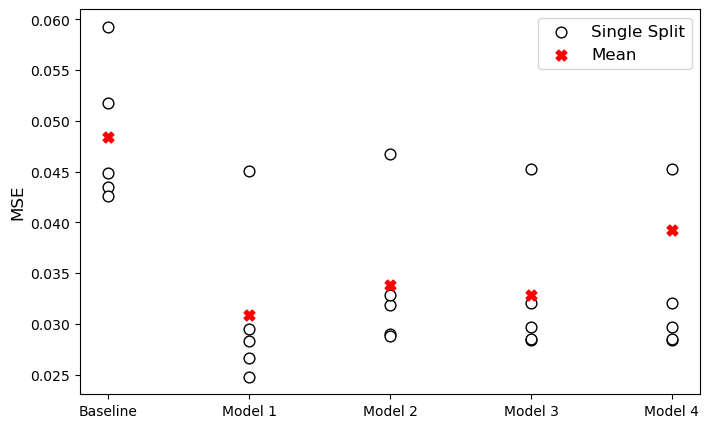

In [51]:
## From Erdos lecture, this figure will graphically compare the performance
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(5), mses[0,:], s=60, c='white', edgecolor='black', label="Single Split")
plt.scatter(np.ones(5), mses[1,:], s=60, c='white', edgecolor='black')
plt.scatter(2*np.ones(5), mses[2,:], s=60, c='white', edgecolor='black')
plt.scatter(3*np.ones(5), mses[3,:], s=60, c='white', edgecolor='black')
plt.scatter(4*np.ones(5), mses[3,:], s=60, c='white', edgecolor='black')
plt.scatter([0,1,2,3,4], np.mean(mses, axis=1), s=60, c='r',marker='X',label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1,2,3, 4],["Baseline", "Model 1", "Model 2", "Model 3", "Model 4"], fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("MSE", fontsize=12)
plt.savefig('images/cross-val-mses.png')
plt.show()

### Testing the Model
- Take the best performing model and use for prediction

In [52]:
# Get the best model
best_model = models[best_model_num]

y_pred = best_model.predict(X_test_scl)
mse_test = mean_squared_error(y_pred, y_test)
print(f'Best Model MSE = {mse_test}')

Best Model MSE = 0.02570476495432105


To interpret the error, we did the following:
1. Multiply the win percentage by 12 season games and round to the nearest number of wins
2. Find the RMSE of the predicted vs. actual wins

In [53]:
print(f'RMSE of Best Model x 12 = {12*np.sqrt(mse_test)}')

RMSE of Best Model x 12 = 1.9239246745707668


Compared to the baseline model RMSE (multiply by 12 to get number of games)

In [54]:
y_pred_base = X_test['prev_win_pct']
print(f'RMSE of Baseline Model x 12 = {12*np.sqrt(mean_squared_error(y_test, y_pred_base))}')

RMSE of Baseline Model x 12 = 2.282922932783502


So we see an improvement over the baseline of...

In [55]:
def percent_diff(a, b):
    return np.abs((a - b) / ((a + b) / 2)) * 100

percent_diff(12*np.sqrt(mse_test),12*np.sqrt(mean_squared_error(y_test, y_pred_base)))

17.067328875196083

### Hyperparameter Tuning using XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
    # Add more parameters as needed
}

### Trying Some Deep Learning Methods
- LSTMs often used for time series

In [72]:
# Reshape data from (samples, features) to (samples, time steps, features)
X_train_scl_reshape = np.reshape(X_train_scl , (X_train_scl.shape[0], 1, X_train_scl.shape[1]))
X_test_scl_reshape = np.reshape(X_test_scl , (X_test_scl.shape[0], 1, X_test_scl.shape[1]))

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 50
num_batches = len(X_train_scl) // BATCH_SIZE


In [70]:
# Make kfold object. Set shuffle=True to maintain time ordering and prevent data leakage from ELO
kfold = TimeSeriesSplit(5)

mses = []
histories = []
i = 0
for i, (train_index, test_index) in enumerate(kfold.split(X_train)):

    X_tt, y_tt = X_train_scl.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train_scl.iloc[test_index], y_train.iloc[test_index]
    X_ho_base, y_ho_base = X_train.iloc[test_index], y_train.iloc[test_index]

    # Reshape data from (samples, features) to (samples, time steps, features)
    X_tt_reshape = np.reshape(X_tt , (X_tt.shape[0], 1, X_tt.shape[1]))
    X_ho_reshape = np.reshape(X_ho , (X_ho.shape[0], 1, X_ho.shape[1]))

    # Baseline model, take previous winning percentage
    pred0 = X_ho_base['prev_win_pct']

    # Declare and Compile Models
    model_lstm = Sequential([
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

    # Train and store history (which includes predictions)
    history = model_lstm.fit(X_tt_reshape, 
            y_tt, 
            epochs=N_EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_ho_reshape, y_ho),
            callbacks=[early_stop],
            verbose=0)
    histories.append(history)

    # Get mses
    mses.append(min(history.history['val_loss']))
    

In [73]:
print(f"MSEs for Each Cross Val: {mses}")
print(f'Average MSE: {np.mean(mses)}')

MSEs for Each Cross Val: [0.02729986421763897, 0.030569111928343773, 0.029130928218364716, 0.04703891649842262, 0.03225584328174591]
Average MSE: 0.0332589328289032


In [74]:
# Get results for test set
y_pred = model_lstm.predict(X_test_scl_reshape)
lstm_error = mean_squared_error(y_pred, y_test)
print(f'LSTM Test MSE: {lstm_error}')

4/4 [==============================] - 0s 6ms/step
LSTM Test MSE: 0.02603916327508988


In [75]:
# Compare to baseline
percent_diff(np.sqrt(lstm_error),np.sqrt(mean_squared_error(y_test, y_pred_base)))

16.42559532318031

/var/folders/70/g0t97b0x2r964_f_p7d3sgwc0000gn/T/ipykernel_15104/3215021690.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


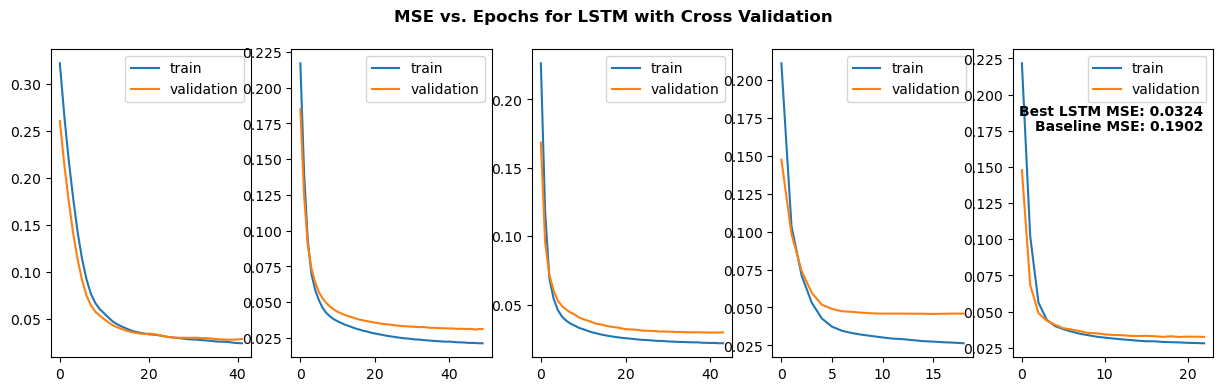

In [64]:
# Plot the loss history
fig, axes = plt.subplots(1,5, figsize=(15,4))
for i, history in enumerate(histories):
    axes[i].plot(history.history['loss'], label='train')
    axes[i].plot(history.history['val_loss'], label='validation')
    axes[i].text(0.95, 0.8, f"Best LSTM MSE: {min(history.history['val_loss']):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
    axes[i].text(0.95, 0.75, f"Baseline MSE: {np.sqrt(mean_squared_error(y_test, y_pred_base)):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
    axes[i].legend()

plt.suptitle('MSE vs. Epochs for LSTM with Cross Validation', fontweight='bold')
plt.tight_layout()
plt.savefig('images/lstm_loss.png')
plt.show()

#### LSTM w/o Cross Validation

In [76]:
BATCH_SIZE = 32
N_EPOCHS = 50
num_batches = len(X_train_scl) // BATCH_SIZE

model = Sequential([
    LSTM(50, activation='relu'),
    Dense(1)
])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scl_reshape, 
            y_train, 
            epochs=N_EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_scl_reshape, y_test),
            callbacks=[early_stop],
            verbose=0)
y_pred = model.predict(X_test_scl_reshape)

Epoch 16: early stopping
4/4 [==============================] - 0s 4ms/step


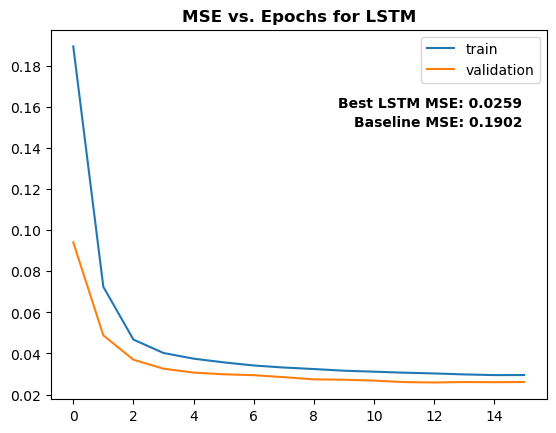

In [77]:
# Plot the loss history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('MSE vs. Epochs for LSTM', fontweight='bold')
plt.text(0.95, 0.8, f"Best LSTM MSE: {min(history.history['val_loss']):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
plt.text(0.95, 0.75, f"Baseline MSE: {np.sqrt(mean_squared_error(y_test, y_pred_base)):.4f}", ha='right', va='center', transform=plt.gca().transAxes, fontweight='bold')
plt.legend()
plt.savefig('images/lstm_loss.png')
plt.show()

In [78]:
# Take the best val_loss convert into % difference with base model
best_mse = min(history.history['val_loss'])

percent_diff(np.sqrt(best_mse),np.sqrt(mean_squared_error(y_test, y_pred_base)))

16.742691265642502